<a href="https://colab.research.google.com/github/Arpitkamal/New-York-headline-Generation/blob/main/New_York_Headline_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# keras module for building LSTM 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku 

# set seeds for reproducability
import tensorflow as tf
from numpy.random import seed
# setting the random seed
tf.random.set_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
curr_dir = os.getcwd()

In [7]:
curr_dir = os.path.join(curr_dir,'ArticlesApril2018.csv')

In [8]:
data = pd.read_csv(curr_dir)

In [9]:
len(data)

1324

In [ ]:
data.headline

0       Former N.F.L. Cheerleaders’ Settlement Offer: ...
1       E.P.A. to Unveil a New Rule. Its Effect: Less ...
2                                 The New Noma, Explained
3                                                 Unknown
4                                                 Unknown
                              ...                        
1319    This Common Question Reinforces the Gender Pay...
1320                                   Anna, Llama and Me
1321           Gen. Michael Hayden Has One Regret: Russia
1322                         There Is Nothin’ Like a Tune
1323                                              Unknown
Name: headline, Length: 1324, dtype: object

In [ ]:
all_headlines = [h for h in data.headline if h != "Unknown"]

In [ ]:
len(all_headlines)

1214

In [ ]:
all_headlines[:10]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?',
 'Commuter Reprogramming',
 'Ford Changed Leaders, Looking for a Lift. It’s Still Looking.',
 'Romney Failed to Win at Utah Convention, But Few Believe He’s Doomed',
 'Chain Reaction',
 'He Forced the Vatican to Investigate Sex Abuse. Now He’s Meeting With Pope Francis.']

# Data Cleaning

In [ ]:
# removing punctuation and converting the word into lower case
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression',
 'commuter reprogramming',
 'ford changed leaders looking for a lift its still looking',
 'romney failed to win at utah convention but few believe hes doomed',
 'chain reaction',
 'he forced the vatican to investigate sex abuse now hes meeting with pope francis']

# Tokenizing the word

 Tokenization is a process of extracting tokens (terms / words) from a corpus. </br>
 In this we convert the corpus of words into dictonary of tokens. Where key being the word and the value being the token assign to it.

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
print(f"Total Number of words: {total_words}")
print(f"Input Sequence :")
inp_sequences[:10]

Total Number of words: 3494
Input Sequence :


[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116]]

### For example 
**Headline:** i stand  with the shedevils  
**Ngrams:** | **Sequence of Tokens**

<table>
<tr><td>Ngram </td><td> Sequence of Tokens</td></tr>
<tr> <td>i stand </td><td> [30, 507] </td></tr>
<tr> <td>i stand with </td><td> [30, 507, 11] </td></tr>
<tr> <td>i stand with the </td><td> [30, 507, 11, 1] </td></tr>
<tr> <td>i stand with the shedevils </td><td> [30, 507, 11, 1, 975] </td></tr>
</table>

# Padding the Sequences 

In this we will convert the input Sequence of X and Y labels



Headline:  i stand  with the shedevils

<table>
<tr><td>X </td> <td>           Y </td></tr>
<tr><td>i                  </td> <td>  stand</td></tr>
<tr><td>i stand               </td> <td>  with</td></tr>
<tr><td>i stand  with     </td> <td>  the</td></tr>
<tr><td>i stand  with the</td> <td>shedevils</td></tr>
</table>

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    # one-hot encoding
    label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [ ]:
predictors

array([[   0,    0,    0, ...,    0,    0,   99],
       [   0,    0,    0, ...,    0,   99,  269],
       [   0,    0,    0, ...,   99,  269,  371],
       ...,
       [   0,    0,    0, ...,  170,    8, 3493],
       [   0,    0,    0, ...,    8, 3493,  115],
       [   0,    0,    0, ..., 3493,  115,    2]], dtype=int32)

In [ ]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
max_sequence_len

24

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
244/244 [==============================] - 16s 23ms/step - loss: 7.5944 - accuracy: 0.0274
Epoch 2/100
244/244 [==============================] - 5s 22ms/step - loss: 6.8259 - accuracy: 0.0557
Epoch 3/100
244/244 [==============================] - 5s 21ms/step - loss: 6.1256 - accuracy: 0.0910
Epoch 4/100
244/244 [==============================] - 5s 21ms/step - loss: 5.1613 - accuracy: 0.1519
Epoch 5/100
244/244 [==============================] - 5s 20ms/step - loss: 4.0139 - accuracy: 0.2646
Epoch 6/100
244/244 [==============================] - 5s 20ms/step - loss: 2.9233 - accuracy: 0.4074
Epoch 7/100
244/244 [==============================] - 5s 20ms/step - loss: 2.1191 - accuracy: 0.5458
Epoch 8/100
244/244 [==============================] - 5s 20ms/step - loss: 1.5319 - accuracy: 0.6631
Epoch 9/100
244/244 [==============================] - 5s 20ms/step - loss: 1.2240 - accuracy: 0.7328
Epoch 10/100
244/244 [==============================] - 5s 20ms/step - loss: 0.98

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           349400    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 3494)              1051694   
                                                                 
Total params: 1,702,294
Trainable params: 1,702,294
Non-trainable params: 0
_________________________________________________________________


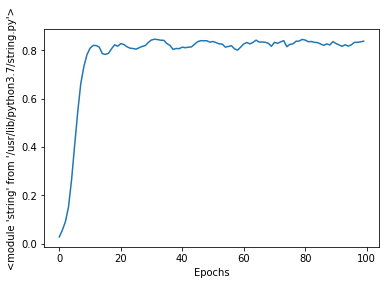

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel(string)
plt.show()

# Generating the text

In [37]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        pred = model.predict(token_list, verbose=0)
        pred = np.argmax(pred,axis=1)
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == pred:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [39]:
all_headlines[3]

'How a Bag of Texas Dirt  Became a Times Tradition'

In [40]:
print (generate_text("How a Bag of Texas Dirt", 5, model, max_sequence_len))

How A Bag Of Texas Dirt Became A Times Tradition Of


In [42]:
print (generate_text("united states", 5, model, max_sequence_len))
print (generate_text("preident trump", 4, model, max_sequence_len))
print (generate_text("donald trump", 4, model, max_sequence_len))
print (generate_text("india and china", 10, model, max_sequence_len))
print (generate_text("new york", 4, model, max_sequence_len))
print (generate_text("science and technology", 5, model, max_sequence_len))

United States Are Doing What Scott Pruitt
Preident Trump Blasts Comey In Barrage
Donald Trump Blasts Comey In Barrage
India And China Is Confident It Can Endorse Rival A Man Pointing A
New York Housing Authority Chief Under
Science And Technology At The Mall To Promote
